In [66]:
import pandas as pd
import pymongo
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandas.core.common import flatten
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as lda
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pickle
import pyLDAvis
from pyLDAvis import sklearn

%matplotlib inline 
pyLDAvis.enable_notebook()




In [5]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
db = client.reddit_comments_db
# Declare the collection
collection = db.comments

In [6]:
# def read_data(doc_collection,amt):
#     print('Enter desired result amount of posts')
#     try:
#         amt = int(input())
#     except Exception as e:
#         print(e)
#         print('Make sure to enter an interger value')
#     for item in doc_collection.find().limit(amt):
#         yield item['comment']
#         print(item['comment'])
   
    

In [40]:
#  load data
data = pd.DataFrame(list(collection.find().limit(10000)))

In [41]:
# filtering out removed comments
data = data[data['comment'] != '[removed]']

In [42]:
# removing links from the text corpus
data = pd.DataFrame(data['comment'].map(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE)))

In [43]:
# checking for null data 
data

,comment
0,A totalitarian states capabilities of shutting...
1,Apparently you do not know what it is to be a ...
2,Men always get hit the hardest during pandemic...
3,My vacuum broke - can uncle sam gimme a new on...
4,"Still probably will be in line with the 30,000..."
5,"Its obviously a dick thing to do, its called c..."
6,&gt; That is one ugly ass teacher\n\nHas anyon...
7,&gt; Getting a little nervous about the contin...
9,&gt; A lot of restaurants by me have closed up...
10,We are all hoping for this to end soon. The pe...


In [44]:
# removing non utf-8 characters from the comment column
data = pd.DataFrame(data['comment'].str.encode('utf-8', 'ignore').str.decode('utf-8'))

In [45]:
# removing punctuation 
data = pd.DataFrame(data.comment.apply(lambda x: re.sub(r'[^\w\s]', '',x)))

In [46]:
data

,comment
0,A totalitarian states capabilities of shutting...
1,Apparently you do not know what it is to be a ...
2,Men always get hit the hardest during pandemic...
3,My vacuum broke can uncle sam gimme a new one...
4,Still probably will be in line with the 30000 ...
5,Its obviously a dick thing to do its called co...
6,gt That is one ugly ass teacher\n\nHas anyone ...
7,gt Getting a little nervous about the continuo...
9,gt A lot of restaurants by me have closed up a...
10,We are all hoping for this to end soon The pea...


In [47]:
# making text all lowercase
data = data.apply(lambda x: x.str.lower())

In [48]:
# tokenizing data
data = data.apply(lambda row: nltk.word_tokenize(row['comment']), axis=1)
data = list(flatten(data))


In [49]:
# Filtering out stop words
stop_words = set(stopwords.words('english')) 
data = [word for word in data if not word in stop_words]

In [50]:
# lematizing data
lemmatizer = WordNetLemmatizer()
data = [lemmatizer.lemmatize(x) for x in data]


In [51]:
# removing digits
# data = pd.DataFrame([x for x in data if not x.isdigit()],columns=['comments'])

In [52]:
#Init count vectorizer
cvec = CountVectorizer(stop_words='english',
                      
                      )

In [53]:
term_mat = cvec.fit_transform(data)


In [54]:
term_df = pd.DataFrame(term_mat.toarray(), columns = cvec.get_feature_names())


In [55]:
term_sums = term_df.sum().sort_values(ascending=False)[:50]

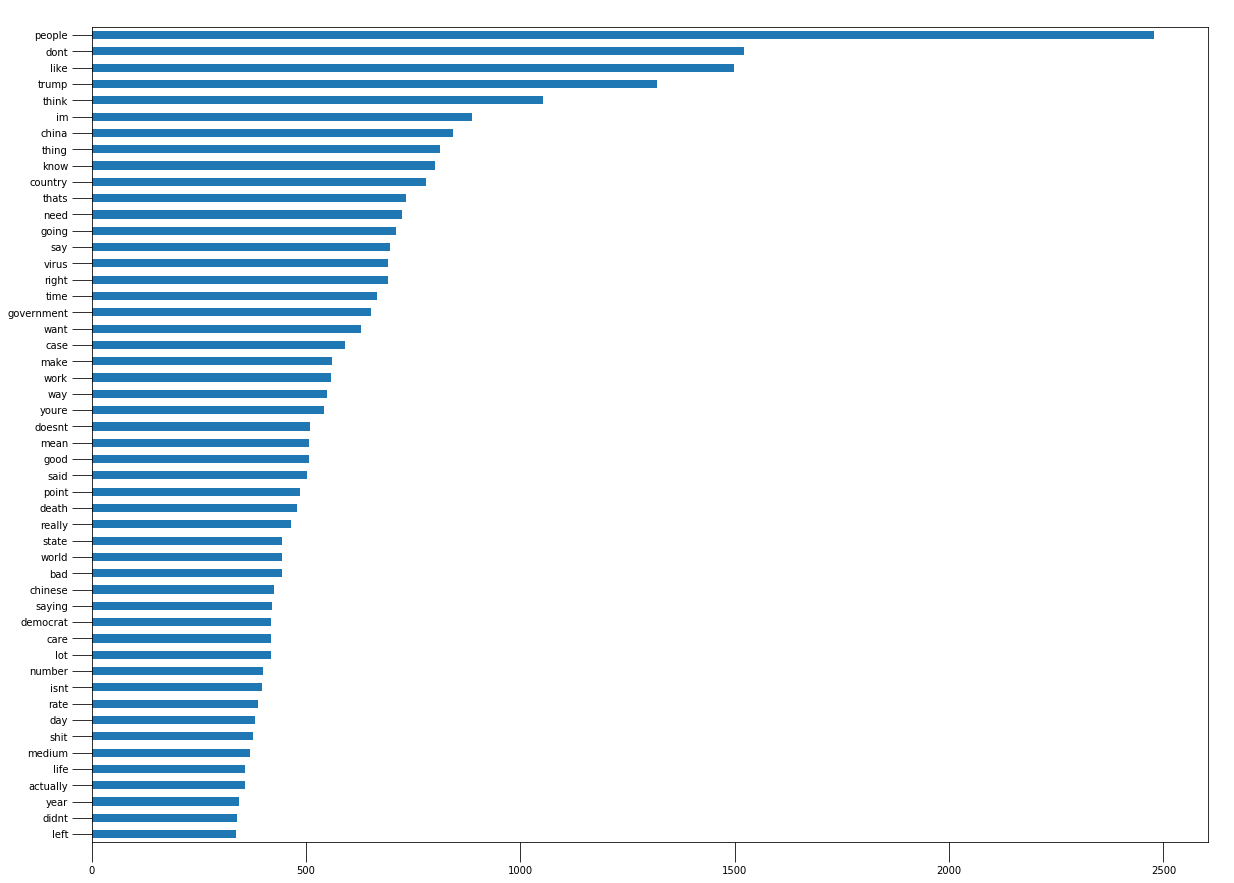

In [56]:
fig, ax = plt.subplots(figsize=(20,15))
ax.tick_params(size=20)
term_sums.sort_values().plot(kind='barh')

In [57]:
# pipe = Pipeline([
#   ('lda',lda(learning_method='online')),
# ])


In [58]:
# param_grid = {
# #     'cvec__max_df':[.45,.50],
#     'lda__n_components':[25,50,75,100],
#     'lda__learning_decay':[.50,.75,.85,.95],
#     'lda__topic_word_prior':np.arange(.1,.25,.5),
#     'lda__learning_offset':[5,10,15,20,25],
# }

In [59]:
# gs = GridSearchCV(pipe, param_grid=param_grid,verbose=1,cv=5)
# gs.fit(term_mat)


In [60]:
final_lda = lda(learning_decay=.85,
               learning_offset=12,
               n_components=25,
               topic_word_prior=.10)

In [61]:
final_lda.fit_transform(term_df)

array([[0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       ...,
       [0.02, 0.52, 0.02, ..., 0.02, 0.02, 0.02],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02]])

In [62]:
# # Best Model
# best_lda_model = gs.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", gs.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", gs.best_score_)

# # Perplexity
# # print("Model Perplexity: ", best_lda_model.get_params.(term_mat))


In [64]:
pyLDAvis.display(pyLDAvis.sklearn.prepare(final_lda, term_mat, cvec, mds='tsne'))